#  Multi-Layer Perceptron (MLP) 

In this worksheet you will apply the Multi-Layer Perceptron (MLP) we saw in class to classify the [MNIST data](https://en.wikipedia.org/wiki/MNIST_database).
For this you will use the high-level [Keras](https://keras.io/getting_started/intro_to_keras_for_engineers/) interface to the [TensorFlow](https://en.wikipedia.org/wiki/TensorFlow) library, as well as *your own implementation*, in order to understand and verify how a Deep Neural Net is trained. Keras provides a user-friendly interface for building and training neural networks, simplifying the process of creating and experimenting with MLP models.

### Loading and ploting the MNIST data

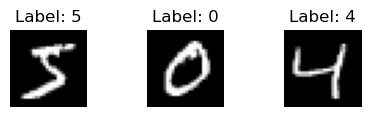

In [16]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Keep only a fraction (frac) of the data ; run ONLY if your computer is slow
frac = 0.2; train_size = int(len(x_train) * frac); test_size = int(len(x_test) * frac)
x_train, y_train = x_train[:train_size], y_train[:train_size]
x_test, y_test = x_test[:test_size], y_test[:test_size]

# Scale the image intensities within the [0,1] range
x_train, x_test = x_train / 255.0, x_test / 255.0 

# PLot the first 3 images in the training set
fig, axes = plt.subplots(1, 3, figsize=(5, 1))
for i in range(3):
    axes[i].imshow(x_train[i], cmap='gray')
    axes[i].set_title(f"Label: {y_train[i]}")
    axes[i].axis('off')
plt.show()

Now preprocess the data for use in the MLP: 
- Normalize all vectors (i.e., subtract the mean and divide by the st.dev. of the training data) 
- Split the data into *mini-batches* for use with Stochastic Gradient Descent (SGD).

E.g. Here we divide training data into mini-batches of 128 samples each. This is a mini-batch size for Stochastic Gradient Descent (SGD). It's common to use smaller batches like 32, 64, or 128 to allow for more frequent weight updates.
Divide test data into larger batches of 1024 for evaluation, here you can use a larger batch size since you’re just doing forward passes (no gradient computation). This makes evaluation faster and more memory efficient.

In [2]:
# standardization
mean = x_train.mean(); std = x_train.std()
x_train, x_test = (x_train - mean) / std, (x_test - mean) / std

# split data into "mini-batches" for SDG
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(1024)

You can inspect the first image of the first mini-batch :

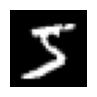

In [3]:
first_batch = next(iter(train_dataset)) # Get the first batch from the train_dataset
first_item = first_batch[0][0] # Access the first item of the first batch

plt.figure(figsize=(2, 1))  # Resize output to smaller dimensions (in inches)
plt.imshow(first_item, cmap='grey'); # Print the dimensions of the first item
plt.axis('off'); plt.show() # hide axes

## Custom MLP

We now create and train a *hard-coded* MLP, using no library other than `numpy` functions. First, we define custom python functions for initializing random Normal parameters (weights & biases), and calculating the ReLU, softmax, cross-entropy, and one-hot encoding functions.

In [4]:
np.random.seed(0)

In [5]:
import numpy as np

def initialize_param(W, b):
    """Initializes weights and biases with random values."""
    W[:] = np.random.randn(*W.shape) * 0.01
    b[:] = np.zeros(b.shape)

def relu(x):
    """ReLU activation function."""
    return np.maximum(0, x)

def softmax(x):
    """Softmax function."""
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(logits, targets):
    """Cross-entropy loss function."""
    probs = softmax(logits)
    num_samples = logits.shape[0]
    one_hot_targets = np.eye(logits.shape[1])[targets]
    loss = -np.sum(one_hot_targets * np.log(probs + 1e-10)) / num_samples  # Added a small epsilon to avoid log(0)
    return loss

def one_hot(labels, num_classes):
    """One-hot encoding."""
    return np.eye(num_classes)[labels]



Next, we initialize the model parameters and train our MLP using Stochastic Gradient Descent (SGD) over 3 epochs. The plot in the end shows the associated metrics (loss & accuracy) versus mini-batch (there are $3 \times (N/128)$ mini-batches, where $N$ is the training data size and 128 is the mini-batch size). 

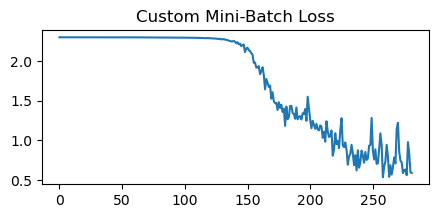

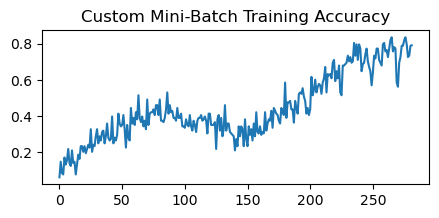

Max Training Accuracy: 0.8359375
Min Loss: 0.5351948420204631


In [6]:
# Parameters
lr = 0.1 # learning rate

# Initialize weights and biases
W1 = np.empty((64, 28*28))
W2 = np.empty((32, 64))
W3 = np.empty((10, 32))
b1 = np.empty(64)
b2 = np.empty(32)
b3 = np.empty(10)
np.random.seed(0)
initialize_param(W1, b1)
initialize_param(W2, b2)
initialize_param(W3, b3)

# initialize lists to store the loss and training accuracy
losses = []
train_acc = []
epochs = 3
num_classes = 10

for epoch in range(epochs):
    for x, y in train_dataset:
        x=x.numpy().reshape(-1, 28 * 28).astype(np.float32); 
        y=y.numpy()

        
        # Forward pass
        z1 = x @ W1.T + b1
        h1 = relu(z1)
        z2 = h1 @ W2.T + b2
        h2 = relu(z2)
        z3 = h2 @ W3.T + b3
        loss = cross_entropy_loss(z3, y)

        # Backward pass
        one_hot_targets = one_hot(y, num_classes)
        probabilities = softmax(z3)
        B = x.shape[0]

        dL_dz3 = (probabilities - one_hot_targets) / B
        dz3_dW3 = h2
        dz3_dh2 = W3
        dh2_dz2 = (h2 > 0).astype(float) #convert boolean mask to float
        dz2_dW2 = h1
        dz2_dh1 = W2
        dh1_dz1 = (h1 > 0).astype(float)

        grad_W3 = dL_dz3.T @ dz3_dW3
        grad_W2 = (dL_dz3 @ dz3_dh2 * dh2_dz2).T @ dz2_dW2
        grad_W1 = ((dL_dz3 @ dz3_dh2 * dh2_dz2) @ dz2_dh1 * dh1_dz1).T @ x

        grad_b3 = np.mean(dL_dz3, axis=0) 
        grad_b2 = np.mean((dL_dz3 @ dz3_dh2 * dh2_dz2), axis=0) 
        grad_b1 = np.mean(((dL_dz3 @ dz3_dh2 * dh2_dz2) @ dz2_dh1 * dh1_dz1), axis=0) 

        # Update parameters
        W3 -= lr * grad_W3
        W2 -= lr * grad_W2
        W1 -= lr * grad_W1
        b3 -= lr * grad_b3
        b2 -= lr * grad_b2
        b1 -= lr * grad_b1

        losses.append(loss)

        # Compute training accuracy
        predictions = np.argmax(probabilities, axis=1)
        num_correct = np.sum(predictions == y)
        num_samples = predictions.size
        train_acc.append(num_correct / num_samples)

# Plot loss and training accuracy
plt.figure(figsize=(5, 2)); plt.plot(losses)
plt.title("Custom Mini-Batch Loss");plt.show()

plt.figure(figsize=(5, 2)); plt.plot(train_acc)
plt.title("Custom Mini-Batch Training Accuracy");plt.show()

print(f"Max Training Accuracy: {max(train_acc)}")
print(f"Min Loss: {min(losses)}")

## Tensorflow

We will now fit the exact same MLP using the Tensor Flow (TF) library, which offers a stearmlined and practical way of speifying and training neural networks. 

In [7]:
import matplotlib.pyplot as plt;import math;import tensorflow as tf;import numpy as np

# Define the model architecture using TensorFlow's Sequential API
model_tf = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),  # Flatten the input data (28x28 images) into a 1D array
    tf.keras.layers.Dense(64, activation='relu'),  # First hidden layer with 64 neurons and ReLU activation
    tf.keras.layers.Dense(32, activation='relu'),  # Second hidden layer with 32 neurons and ReLU activation
    tf.keras.layers.Dense(10),  # Output layer with 10 neurons (one for each class)
    tf.keras.layers.Softmax()  # Softmax activation for the output layer to get probabilities
])

# Define the loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

# Compile the model with the optimizer, loss function, and metrics
model_tf.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, weight_decay=0),
                                 loss=loss_fn, metrics=['accuracy'])

In [8]:
# Custom callback function to store and plot the loss for each batch
class BatchLossPlotter(tf.keras.callbacks.Callback):
        def __init__(self):
                self.batch_losses = []  # List to store loss values for each batch
                self.batch_accuracy = []  # List to store accuracy values for each batch
        
        def on_train_batch_end(self, batch, logs=None):
                loss = logs['loss']  # Get the loss value from the logs
                accuracy = logs['accuracy']  # Get the accuracy value from the logs
                self.batch_losses.append(loss)  # Append the loss value to the list
                self.batch_accuracy.append(accuracy)  # Append the accuracy value to the list

# Instantiate the custom callback
batch_loss_plotter = BatchLossPlotter()

# Train the model with the training data, using the custom callback
history = model_tf.fit(x_train, y_train, epochs=3, batch_size=128, callbacks=[batch_loss_plotter])


Epoch 1/3
94/94 [==============================] - 1s 2ms/step - loss: 0.5848 - accuracy: 0.8242
Epoch 2/3
94/94 [==============================] - 0s 1ms/step - loss: 0.2400 - accuracy: 0.9303
Epoch 3/3
94/94 [==============================] - 0s 1ms/step - loss: 0.1620 - accuracy: 0.9521


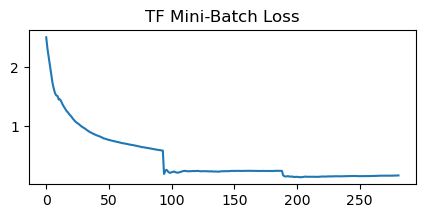

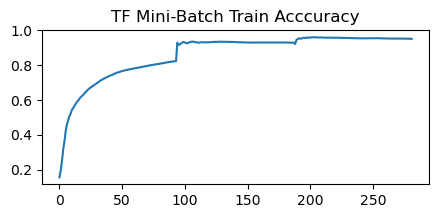

In [9]:
plt.figure(figsize=(5, 2)); plt.plot(batch_loss_plotter.batch_losses)
plt.title("TF Mini-Batch Loss"); plt.show()

plt.figure(figsize=(5, 2)); plt.plot(batch_loss_plotter.batch_accuracy)
plt.title("TF Mini-Batch Train Acccuracy");plt.show()

## Test Set Evaluation

The following code applies the trained Custom and TF MLP to the the test data, and compares their performance. Note that TF has slightly better test set performance, on top of being much faster (TF is optimized for NN calculations on various hardware).

In [10]:
import matplotlib.pyplot as plt;import math;import tensorflow as tf;import numpy as np
# Tensor Flow 
tf_test_loss, tf_test_acc = model_tf.evaluate(x_test,  y_test)
avg_tf_test_loss = np.mean(tf_test_loss) 
avg_tf_test_acc = np.mean(tf_test_acc)
print("Tensor flow: Average test loss =",avg_tf_test_loss, "and Average test accuracy = ",avg_tf_test_acc)

63/63 [==============================] - 0s 1ms/step - loss: 0.4107 - accuracy: 0.8910
Tensor flow: Average test loss = 0.41066187620162964 and Average test accuracy =  0.890999972820282


In [11]:
## Custom
Custom_test_loss = []
Custom_test_acc = []

for x, y in test_dataset:
    x = x.numpy().reshape(-1, 28 * 28).astype(np.float32)  # flatten image into vector 
    y = y.numpy()

    B = x.shape[0]  # This is the batch size
    z1 = x @ W1.T + b1
    h1 = relu(z1)
    z2 = h1 @ W2.T + b2
    h2 = relu(z2)
    z3 = h2 @ W3.T + b3
    loss = cross_entropy_loss(z3, y)

    # Calculate backprop errors
    oneHotTargets = one_hot(y, 10)
    probabilities = softmax(z3)

    Custom_test_loss.append(loss)

    # Compute test accuracy
    predictions = np.argmax(probabilities, axis=1)
    num_correct = np.sum(predictions == y)
    num_samples = predictions.size
    Custom_test_acc.append(num_correct / num_samples)

avg_Custom_test_loss = np.mean(Custom_test_loss)
avg_Custom_test_acc = np.mean(Custom_test_acc)
print("Custom: Average test loss =",avg_Custom_test_loss, "and average test accuracy = ",avg_Custom_test_acc)

Custom: Average test loss = 0.812274133307534 and average test accuracy =  0.748078893442623


In [12]:
# Comparison
print("Average test loss for: \n Custom =", np.round(avg_Custom_test_loss,4), " |  Tensor Flow = ", np.round(avg_tf_test_loss,4))
print("Average test accuracy for \n Custom =", np.round(avg_Custom_test_acc,4), " |  Tensor Flow = ", np.round(avg_tf_test_acc,4))

Average test loss for: 
 Custom = 0.8123  |  Tensor Flow =  0.4107
Average test accuracy for 
 Custom = 0.7481  |  Tensor Flow =  0.891


## MLP Architecture 

Now that you understand how the MLP works, you can experiment with its architecutre and see its effects. Try to fit an MLP with 4 layers of 64, 32, 16, and 10 dimensions (*deeper*), and another one with 2 layers of 124, 64, and 10 dimentions (*wider*) with the same activation functions. How do the models compare on the test set?

In [13]:
import matplotlib.pyplot as plt;import math; import tensorflow as tf;import numpy as np
# Define the deeper MLP model architecture using TensorFlow's Sequential API
deeper_model_tf = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),  # Flatten the input data (28x28 images) into a 1D array
    tf.keras.layers.Dense(64, activation='relu'),  # First hidden layer with 64 neurons and ReLU activation
    tf.keras.layers.Dense(32, activation='relu'),  # Second hidden layer with 32 neurons and ReLU activation
    tf.keras.layers.Dense(16, activation='relu'),  # Third hidden layer with 16 neurons and ReLU activation
    tf.keras.layers.Dense(10),  # Output layer with 10 neurons (one for each class)
    tf.keras.layers.Softmax()  # Softmax activation for the output layer to get probabilities
])

# Define the loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

# Compile the deeper model with the optimizer, loss function, and metrics
deeper_model_tf.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, weight_decay=0),
                        loss=loss_fn, metrics=['accuracy'])

# Train the deeper model with the training data
deeper_history = deeper_model_tf.fit(x_train, y_train, epochs=3, batch_size=128)

# Evaluate the deeper model on the test data
deeper_test_loss, deeper_test_acc = deeper_model_tf.evaluate(x_test, y_test)
avg_deeper_test_loss, avg_deeper_test_acc = np.mean(deeper_test_loss), np.mean(deeper_test_acc)
print("Deeper: Average test loss =",avg_deeper_test_loss, "and Average test accuracy = ",avg_deeper_test_acc)

Epoch 1/3
94/94 [==============================] - 1s 2ms/step - loss: 0.7325 - accuracy: 0.7682
Epoch 2/3
94/94 [==============================] - 0s 1ms/step - loss: 0.2818 - accuracy: 0.9216
Epoch 3/3
63/63 [==============================] - 0s 1ms/step - loss: 0.3721 - accuracy: 0.8975
Deeper: Average test loss = 0.3721367120742798 and Average test accuracy =  0.8974999785423279


In [14]:
import matplotlib.pyplot as plt;import math; import tensorflow as tf;import numpy as np
# Define the wider MLP model architecture using TensorFlow's Sequential API
wider_model_tf = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),  # Flatten the input data (28x28 images) into a 1D array
    tf.keras.layers.Dense(124, activation='relu'),  # First hidden layer with 124 neurons and ReLU activation
    tf.keras.layers.Dense(64, activation='relu'),  # Second hidden layer with 64 neurons and ReLU activation
    tf.keras.layers.Dense(10),  # Output layer with 10 neurons (one for each class)
    tf.keras.layers.Softmax()  # Softmax activation for the output layer to get probabilities
])

# Define the loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

# Compile the wider model with the optimizer, loss function, and metrics
wider_model_tf.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, weight_decay=0),
                       loss=loss_fn, metrics=['accuracy'])

# Train the wider model with the training data
wider_history = wider_model_tf.fit(x_train, y_train, epochs=3, batch_size=128)

# Evaluate the wider model on the test data
wider_test_loss, wider_test_acc = wider_model_tf.evaluate(x_test, y_test)
avg_wider_test_loss, avg_wider_test_acc =np.mean(wider_test_loss),np.mean(wider_test_acc)
print("Wider: Average test loss =",avg_wider_test_loss, "and Average test accuracy = ",avg_wider_test_acc)

Epoch 1/3
94/94 [==============================] - 0s 2ms/step - loss: 0.5120 - accuracy: 0.8453
Epoch 2/3
94/94 [==============================] - 0s 2ms/step - loss: 0.1850 - accuracy: 0.9467
Epoch 3/3
63/63 [==============================] - 0s 1ms/step - loss: 0.3216 - accuracy: 0.9225
Wider: Average test loss = 0.3216448426246643 and Average test accuracy =  0.9225000143051147


In [15]:
# Comparison
print("Average test loss for: \n Original = ", np.round(np.mean(tf_test_loss),4), "  |  Deeper =", np.round(np.mean(deeper_test_loss),4), " |  Wider = ", np.round(np.mean(wider_test_loss),4))
print("Average test accuracy for \n Original = ", np.round(np.mean(tf_test_acc),4), "  |  Deeper =", np.round(np.mean(deeper_test_acc),4), " |  Wider = ", np.round(np.mean(wider_test_acc),4))

Average test loss for: 
 Original =  0.4107   |  Deeper = 0.3721  |  Wider =  0.3216
Average test accuracy for 
 Original =  0.891   |  Deeper = 0.8975  |  Wider =  0.9225
